# Acceptance Probabilities
First, of course, libraries.

In [11]:
# LIBRARIES
library(stringr)

### Check for file existence and matrix existence
In the following block, I'm going to find where the log text file exists. If it exists, then I'm going to see if a matrix exists in the file. I am saving this information in the dataframe called ```df```.

In [2]:
# DATA
# ds_folder = "D:/Dropbox/MCMC_diagnosis/1_data/"
ds_folder = "/Users/treehouse3/Dropbox/MCMC_diagnosis/1_data/"
datasets = list.files(ds_folder)

log_exists = rep(0,223)
search_exists = rep(0,223)

i=1
for (ds in datasets){
  # CHECK FOR FILE
    if (file.exists(paste0(ds_folder,ds,"/original_run/",ds,"_log.txt"))) {
      log_exists[i] = log_exists[i] + 1
      
      this_scan = scan(paste0(ds_folder,ds,"/original_run/",ds,"_log.txt"), what="character", sep="\n")
      search_query = "Chain swap information for run"
      # CHECK FOR SEARCH
      if (any(grepl(search_query, this_scan))) {
        search_exists[i] = search_exists[i] + 1
      }
    }
  i = i+1
}

df = data.frame(cbind(datasets, log_exists, search_exists))

In [3]:
# NUMBER OF STUDIES
length(datasets)

[1] 223

In [4]:
# PREVIEW
head(df, 15)

datasets,log_exists,search_exists
S10036,0,0
S10096,0,0
S10116,0,0
S10167,0,0
S10178,0,0
S10254,0,0
S1070,1,1
S10908,0,0
S1115,1,0
S11161,0,0


In [6]:
cat(100*length(which(df[,2]==1)) / 223, "and", 100*length(which(df[,3]==1)) / 223)

1.345291 and 0.4484305

We have found that 1% of all the studies have the log file, and 0.44% of all the studies have matrices in those log files.

### Collect acceptance probabilities from matrices
In the next code block, I am going to collect the acceptances probabilities in a loop. I'm saving the information to list, then I'm going to convert the list into a dataframe.

In [12]:
# FOR ONLY THE ONES THAT HAVE THE FILE
save_data = list()
for (ds in datasets[which(df[,3]==1)]) {
  # SCAN IN THE TEXT
  this = scan(paste0(ds_folder,ds,"/original_run/",ds,"_log.txt"), what="character", sep="\n")
  start_lines = which(grepl("Chain swap information", this))
  
  i = 1
  for (starting_point in start_lines) {
    m = this[(starting_point+3):(starting_point+6)]
    acceptances = unlist(lapply(str_extract_all(m, "\\.[0-9]{2}"), as.double))
    save_data[[paste0(ds,"-",i)]] = acceptances
    i = i + 1
  }
}

In [13]:
# PREVIEW
save_data

$`S1070-1`
[1] 0.28 0.04 0.00 0.34 0.06 0.37

$`S1070-2`
[1] 0.28 0.05 0.00 0.35 0.08 0.40

$`S1070-3`
[1] 0.27 0.04 0.00 0.34 0.07 0.39

$`S1070-4`
[1] 0.28 0.04 0.00 0.35 0.08 0.40

In [14]:
# WRITE THE CSV
acceptance_rate_df = data.frame(t(data.frame(save_data)))
# write.csv(acceptance_rate_df, file="/Users/treehouse3/Dropbox/acceptance_rates.csv")

In [15]:
# PREVIEW
head(acceptance_rate_df, 15)

,X1,X2,X3,X4,X5,X6
S1070.1,0.28,0.04,0,0.34,0.06,0.37
S1070.2,0.28,0.05,0,0.35,0.08,0.40
S1070.3,0.27,0.04,0,0.34,0.07,0.39
S1070.4,0.28,0.04,0,0.35,0.08,0.40


### Histogram and summary statistics
We have that 5.81% of all acceptance probabilities within these datasets fall below 20% and 44.67% of them fall above 60%.

In [16]:
summary(unlist(save_data))
cat(100*(length(which(unlist(save_data)<0.2)) / length(unlist(save_data))), "and", 100*(length(which(unlist(save_data)>0.6)) / length(unlist(save_data))))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0400  0.1750  0.1879  0.3425  0.4000 

50 and 0

In [17]:
# GET VIOLATING STUDIES
violating_studies = c()
for (i in 1:length(acceptance_rate_df[,1])) {
  if(any((acceptance_rate_df[i,]<0.2) | (acceptance_rate_df[i,]>0.6))) {
    violating_studies = c(violating_studies, rownames(acceptance_rate_df)[i])
  }
}
violating_studies = unique(unlist(lapply(violating_studies, function(x) gsub("\\.[0-9]{1}", "", x))))

In [18]:
# PREVIEW
violating_studies[1:15]

[1] "S1070" NA      NA      NA      NA      NA      NA      NA      NA     
[10] NA      NA      NA      NA      NA      NA

In [24]:
100*length(violating_studies) / 223

[1] 0.4484305

0.448% of all of these included studies have acceptance ratios outside of the range of 20-60%.

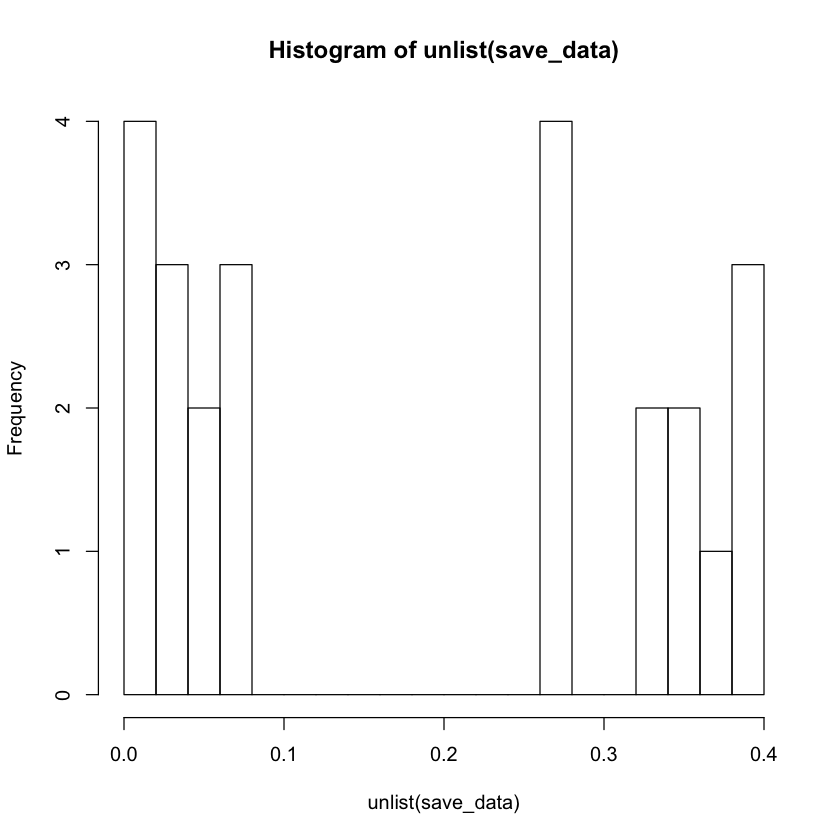

In [22]:
# # VISUALS .. UNCOMMENT THIS IF RERUNNING
# h = hist(unlist(save_data),
#      breaks = 20)

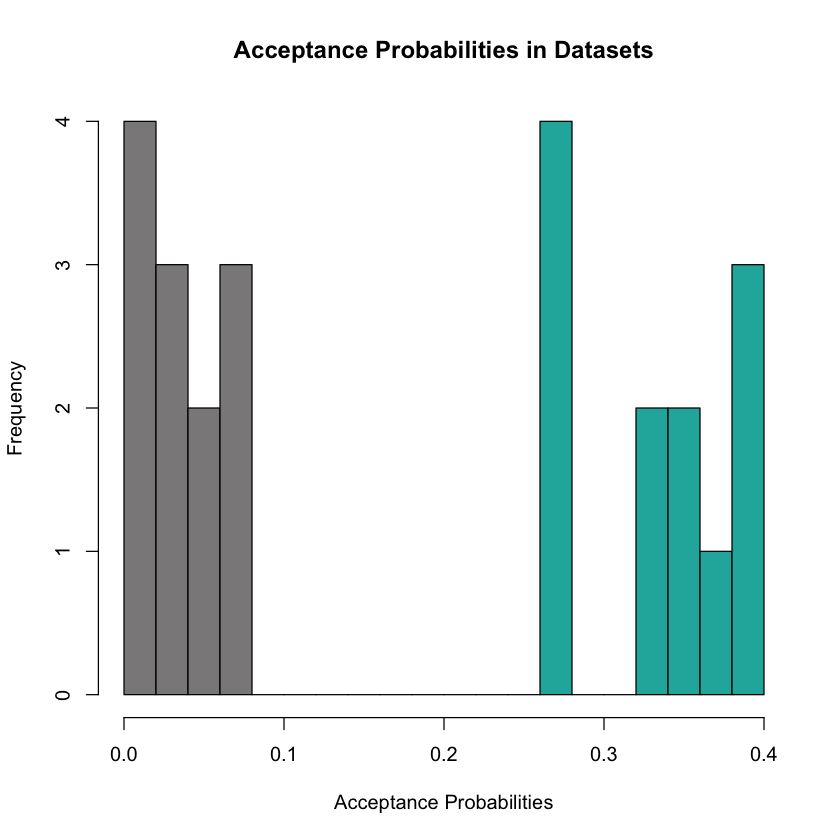

In [23]:
kulay = ifelse((h$breaks < 0.2) | (h$breaks > 0.6), "snow4", "lightseagreen")[-length(h$breaks)]
plot(h, 
     col=kulay, 
     xlab="Acceptance Probabilities", 
     main="Acceptance Probabilities in Datasets")